In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import glob
import numpy as np
from numpy.random import default_rng
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import cv2
import joblib
from utils import *

In [2]:
paraTrainFolder = glob.glob("Data/training_set/Parasitized/*")
noParaTrainFolder = glob.glob("Data/training_set/Uninfected/*")
paraTestFolder = glob.glob("Data/testing_set/Parasitized/*")
noParaTestFolder = glob.glob("Data/testing_set/Uninfected/*")
paraValidFolder = glob.glob("Data/validation_set/Parasitized/*")
noParaValidFolder = glob.glob("Data/validation_set/Uninfected/*")

In [3]:
trainSize = 400
rng = default_rng()
paraTrainIndexes = rng.choice(len(paraTrainFolder), trainSize,replace=False)
paraTrain = [cv2.cvtColor(mpimg.imread(paraTrainFolder[i]),cv2.COLOR_RGB2LAB) for i in paraTrainIndexes]
noParaTrainIndexes = rng.choice(len(noParaTrainFolder), trainSize, replace=False)
noParaTrain = [cv2.cvtColor(mpimg.imread(noParaTrainFolder[i]),cv2.COLOR_RGB2LAB) for i in noParaTrainIndexes]
trainData = paraTrain + noParaTrain
trainLabels = [True]*trainSize + [False]*trainSize

validSize = 80
paraValidIndexes = rng.choice(len(paraValidFolder), validSize,replace=False)
paraValid = [cv2.cvtColor(mpimg.imread(paraValidFolder[i]),cv2.COLOR_RGB2LAB) for i in paraValidIndexes]
noParaValidIndexes = rng.choice(len(noParaValidFolder), validSize, replace=False)
noParaValid = [cv2.cvtColor(mpimg.imread(noParaValidFolder[i]),cv2.COLOR_RGB2LAB) for i in noParaValidIndexes]
validData = paraValid + noParaValid
validLabels = [True]*len(paraValid) + [False]*len(noParaValid)

testSize = 80
paraTestIndexes = rng.choice(len(paraTestFolder), testSize,replace=False)
paraTest = [cv2.cvtColor(mpimg.imread(paraTestFolder[i]),cv2.COLOR_RGB2LAB) for i in paraTestIndexes]
noParaTestIndexes = rng.choice(len(noParaTestFolder), testSize, replace=False)
noParaTest = [cv2.cvtColor(mpimg.imread(noParaTestFolder[i]),cv2.COLOR_RGB2LAB) for i in noParaTestIndexes]
testData = paraTest + noParaTest
testLabels = [True]*len(paraTest) + [False]*len(noParaTest)

In [4]:
trainHist = [CatColorHistogram(i, 20) for i in trainData]
validHist = [CatColorHistogram(i, 20) for i in validData]
testHist = [CatColorHistogram(i, 20) for i in testData]

In [5]:
penalty = ["l1", "l2","elasticnet","none"]
class_weights = ["balanced",None]
solvers = ["lbfgs", "sag", "saga","newton-cg", "liblinear"]
logitModel = LogisticRegression(penalty=penalty[1],class_weight=class_weights[0],solver=solvers[0]).fit(trainHist, trainLabels)
pscore_logit = logitModel.predict_proba(validHist)
logit_predictions = logitModel.predict(validHist)
joblib.dump(logitModel,'Models/logit_res.pkl')

['Models/logit_res.pkl']

In [6]:
pscore_knn = None
max_kscore_knn = 0
knnModel = None
knn_predictions = None
for i in range(1, 22, 2):
    knnClas = KNeighborsClassifier(n_neighbors=i)
    knnClas.fit(trainHist, trainLabels)
    temp_predictions = knnClas.predict(validHist)
    fscore_knn = f1_score(validLabels, temp_predictions)
    if fscore_knn > max_kscore_knn:
        knn_predictions = temp_predictions
        max_fscore_knn = fscore_knn
        pscore_knn = knnClas.predict_proba(validHist)
        knnModel = knnClas
joblib.dump(knnModel, 'Models/knnClas.pkl')

['Models/knnClas.pkl']

In [7]:
criterion = 'gini' #gini or entropy
max_features = 'sqrt' #sqrt || log2 || None
max_depth = None
randomForestClas = RandomForestClassifier(n_estimators=100,criterion=criterion,max_features=max_features,max_depth=max_depth)
randomForestClas.fit(trainHist, trainLabels)
pscore_forest = randomForestClas.predict_proba(validHist)
forest_predictions = randomForestClas.predict(validHist)
joblib.dump(randomForestClas, 'Models/randomForestClas.pkl')

['Models/randomForestClas.pkl']

In [8]:
kernel = ['linear','poly','rbf','sigmoid']
class_weight = [None,'balanced']
SVC_model = SVC(probability = True, kernel= kernel[0], class_weight = class_weight[0])
SVC_model.fit(trainHist,trainLabels)

pscore_SVC = SVC_model.predict_proba(validHist)
SVC_predictions = SVC_model.predict(validHist)
joblib.dump(SVC_model, 'Models/SVC_model.pkl')

['Models/SVC_model.pkl']

In [9]:
# generate a no skill prediction
ns_probs = [0 for _ in range(len(validLabels))]
no_skill = np.count_nonzero(validLabels) / len(validLabels)

# calculate curves
ns_fpr, ns_tpr, _ = roc_curve(validLabels, ns_probs)
logit_fpr, logit_tpr, _ = roc_curve(validLabels, pscore_logit[:, 1])
forest_fpr, forest_tpr, _ = roc_curve(validLabels, pscore_forest[:, 1])
knn_fpr, knn_tpr, _ = roc_curve(validLabels, pscore_knn[:, 1])
SVC_fpr, SVC_tpr, _ = roc_curve(validLabels, pscore_SVC[:, 1])

ns_precision, ns_recall, _ = precision_recall_curve(validLabels, ns_probs)
logit_precision, logit_recall, _ = precision_recall_curve(
    validLabels, pscore_logit[:, 1])
forest_precision, forest_recall, _ = precision_recall_curve(
    validLabels, pscore_forest[:, 1])
knn_precision, knn_recall, _ = precision_recall_curve(
    validLabels, pscore_knn[:, 1])
SVC_precision, SVC_recall, _ = precision_recall_curve(validLabels, pscore_SVC[:, 1])


# calculate scores
ns_auc_roc = auc(ns_fpr, ns_tpr)
logit_auc_roc = auc(logit_fpr, logit_tpr)
forest_auc_roc = auc(forest_fpr, forest_tpr)
knn_auc_roc = auc(knn_fpr, knn_tpr)
SVC_auc_roc = auc(SVC_fpr, SVC_tpr)

ns_auc_pr = auc([0, 1], [no_skill, no_skill])
logit_auc_pr = auc(logit_recall, logit_precision)
forest_auc_pr = auc(forest_recall, forest_precision)
knn_auc_pr = auc(knn_recall, knn_precision)
SVC_auc_pr = auc(SVC_recall, SVC_precision)

# summarize scores
print("------------------------>Validation Set<------------------------")
print("-------------------->Precision<--------------------")
print('Logistic: %.3f' % (precision_score(validLabels, logit_predictions)))
print('Random Forest: %.3f' % (precision_score(validLabels, forest_predictions)))
print('KNN: %.3f' % (precision_score(validLabels, knn_predictions)))
print('SVC: %.3f' % (precision_score(validLabels, SVC_predictions)))
print("-------------------->Recall<--------------------")
print('Logistic: %.3f' % (recall_score(validLabels, logit_predictions)))
print('Random Forest: %.3f' % (recall_score(validLabels, forest_predictions)))
print('KNN: %.3f' % (recall_score(validLabels, knn_predictions)))
print('SVC: %.3f' % (recall_score(validLabels, SVC_predictions)))
print("-------------------->F1<--------------------")
print('Logistic: %.3f' % (f1_score(validLabels, logit_predictions)))
print('Random Forest: %.3f' % (f1_score(validLabels, forest_predictions)))
print('KNN: %.3f' % (f1_score(validLabels, knn_predictions)))
print('SVC: %.3f' % (f1_score(validLabels, SVC_predictions)))


print("-------------------->ROC<--------------------")
print('No Skill: ROC AUC=%.3f' % (ns_auc_roc))
print('Logistic: ROC AUC=%.3f' % (logit_auc_roc))
print('Random Forest: ROC AUC=%.3f' % (forest_auc_roc))
print('KNN: ROC AUC=%.3f' % (knn_auc_roc))
print('SVC: ROC AUC=%.3f' % (SVC_auc_roc))

print("-------------------->Precision-Recall<--------------------")
print('No Skill: Precision-Recall AUC=%.3f' % (ns_auc_pr))
print('Logistic: Precision-Recall AUC=%.3f' % (logit_auc_pr))
print('Random Forest: Precision-Recall AUC=%.3f' % (forest_auc_pr))
print('KNN: Precision-Recall AUC=%.3f' % (knn_auc_pr))
print('SVC: Precision-Recall AUC=%.3f' % (SVC_auc_pr))

------------------------>Validation Set<------------------------
-------------------->Precision<--------------------
Logistic: 0.937
Random Forest: 0.975
KNN: 0.987
SVC: 0.925
-------------------->Recall<--------------------
Logistic: 0.925
Random Forest: 0.963
KNN: 0.975
SVC: 0.925
-------------------->F1<--------------------
Logistic: 0.931
Random Forest: 0.969
KNN: 0.981
SVC: 0.925
-------------------->ROC<--------------------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.985
Random Forest: ROC AUC=0.985
KNN: ROC AUC=0.993
SVC: ROC AUC=0.985
-------------------->Precision-Recall<--------------------
No Skill: Precision-Recall AUC=0.500
Logistic: Precision-Recall AUC=0.987
Random Forest: Precision-Recall AUC=0.990
KNN: Precision-Recall AUC=0.993
SVC: Precision-Recall AUC=0.985


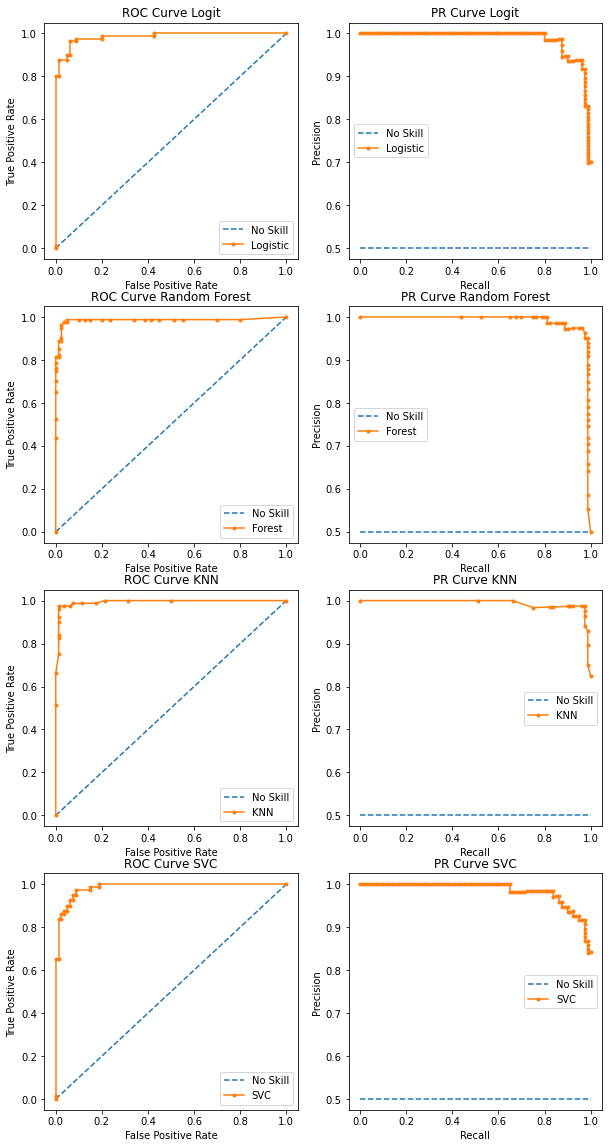

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
#plot the curve for the model
axs[0][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[0][0].plot(logit_fpr, logit_tpr, marker='.', label='Logistic')
axs[1][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[1][0].plot(forest_fpr, forest_tpr, marker='.', label='Forest')
axs[2][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[2][0].plot(knn_fpr, knn_tpr, marker='.', label='KNN')
axs[3][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[3][0].plot(SVC_fpr, SVC_tpr, marker='.', label='SVC')

axs[0][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[0][1].plot(logit_recall, logit_precision, marker='.', label='Logistic')
axs[1][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1][1].plot(forest_recall, forest_precision, marker='.', label='Forest')
axs[2][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[2][1].plot(knn_recall, knn_precision, marker='.', label='KNN')
axs[3][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[3][1].plot(SVC_recall, SVC_precision, marker='.', label='SVC')

# axis labels
plt.setp(axs[0][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Logit")
plt.setp(axs[0][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Logit")
plt.setp(axs[1][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Random Forest")
plt.setp(axs[1][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Random Forest")
plt.setp(axs[2][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve KNN")
plt.setp(axs[2][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve KNN")
plt.setp(axs[3][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve SVC")
plt.setp(axs[3][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve SVC")

# show the legend
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
axs[2][0].legend()
axs[2][1].legend()
axs[3][0].legend()
axs[3][1].legend()

In [11]:
logit_predictions = logitModel.predict(testHist)
forest_predictions = randomForestClas.predict(testHist)
knn_predictions = knnModel.predict(testHist)
SVC_predictions = SVC_model.predict(testHist)

print("------------------------>Testing Set<------------------------")
print("-------------------->Precision<--------------------")
print('Logistic: %.3f' % (precision_score(testLabels, logit_predictions)))
print('Random Forest: %.3f' % (precision_score(testLabels, forest_predictions)))
print('KNN: %.3f' % (precision_score(testLabels, knn_predictions)))
print('SVC: %.3f' % (precision_score(testLabels, SVC_predictions)))
print("-------------------->Recall<--------------------")
print('Logistic: %.3f' % (recall_score(testLabels, logit_predictions)))
print('Random Forest: %.3f' % (recall_score(testLabels, forest_predictions)))
print('KNN: %.3f' % (recall_score(testLabels, knn_predictions)))
print('SVC: %.3f' % (recall_score(testLabels, SVC_predictions)))
print("-------------------->F1<--------------------")
print('Logistic: %.3f' % (f1_score(testLabels, logit_predictions)))
print('Random Forest: %.3f' % (f1_score(testLabels, forest_predictions)))
print('KNN: %.3f' % (f1_score(testLabels, knn_predictions)))
print('SVC: %.3f' % (f1_score(testLabels, SVC_predictions)))

------------------------>Testing Set<------------------------
-------------------->Precision<--------------------
Logistic: 0.950
Random Forest: 0.974
KNN: 0.974
SVC: 0.949
-------------------->Recall<--------------------
Logistic: 0.950
Random Forest: 0.925
KNN: 0.950
SVC: 0.938
-------------------->F1<--------------------
Logistic: 0.950
Random Forest: 0.949
KNN: 0.962
SVC: 0.943


(0.0, 1.0, 0.0, 1.0)

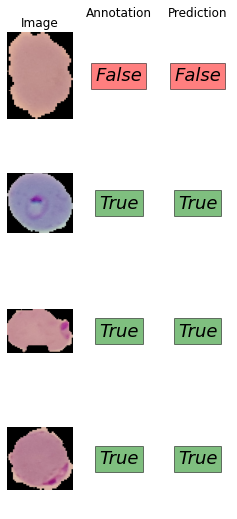

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(4,9))

indexes = rng.choice(len(testData), 4,replace=False)
axes[0][0].set_title("Image")
axes[0][1].set_title("Annotation")
axes[0][2].set_title("Prediction")

axes[0][0].imshow(cv2.cvtColor(testData[indexes[0]], cv2.COLOR_LAB2RGB))
axes[0][0].axis("off")
axes[0][1].text(0.5, 0.5, str(testLabels[indexes[0]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[0]] else "red", 'alpha': 0.5},fontsize=18)
axes[0][1].axis("off")
axes[0][2].text(0.5, 0.5, str(forest_predictions[indexes[0]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[0]] else "red", 'alpha': 0.5},fontsize=18)
axes[0][2].axis("off")

axes[1][0].imshow(cv2.cvtColor(testData[indexes[1]],cv2.COLOR_LAB2RGB))
axes[1][0].axis("off")
axes[1][1].text(0.5, 0.5, str(testLabels[indexes[1]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[1]] else "red", 'alpha': 0.5},fontsize=18)
axes[1][1].axis("off")
axes[1][2].text(0.5, 0.5, str(forest_predictions[indexes[1]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[1]] else "red", 'alpha': 0.5},fontsize=18)
axes[1][2].axis("off")

axes[2][0].imshow(cv2.cvtColor(testData[indexes[2]],cv2.COLOR_LAB2RGB))
axes[2][0].axis("off")
axes[2][1].text(0.5, 0.5, str(testLabels[indexes[2]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[2]] else "red", 'alpha': 0.5},fontsize=18)
axes[2][1].axis("off")
axes[2][2].text(0.5, 0.5, str(forest_predictions[indexes[2]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[2]] else "red", 'alpha': 0.5},fontsize=18)
axes[2][2].axis("off")

axes[3][0].imshow(cv2.cvtColor(testData[indexes[3]],cv2.COLOR_LAB2RGB))
axes[3][0].axis("off")
axes[3][1].text(0.5, 0.5, str(testLabels[indexes[3]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[3]] else "red", 'alpha': 0.5},fontsize=18)
axes[3][1].axis("off")
axes[3][2].text(0.5, 0.5, str(forest_predictions[indexes[3]]), style='italic',horizontalalignment='center', verticalalignment='center',bbox={'facecolor': 'green' if testLabels[indexes[3]] else "red", 'alpha': 0.5},fontsize=18)
axes[3][2].axis("off")